## Import libraries

In [216]:
import pandas as pd
from os import listdir
from os.path import isfile, join
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from datetime import datetime
from ast import literal_eval
import re
import numpy as np
from pyzipcode import ZipCodeDatabase

## Set directories

In [217]:
abspath_curr = os.path.join(os.getcwd())
data_path = os.path.join(abspath_curr, 'data')

## Read in dataframes and concatenate them

In [218]:
def stitch_frames(data_path):
    frames = []
    for subdir, dirs, files in os.walk(data_path):
        for file in files:
            if subdir.endswith('run') and file.endswith('tweets.csv'):
                path = os.path.join(subdir, file)
                df = pd.read_csv(path, index_col=None, header=0)
                df = df.rename(columns={'handle_name': 'screen_name', 'name': 'user_name', 'hashtags': 'hashtags_text', 'text': 'tweet_text', 'place': 'location'})
                frames.append(df)
    df = pd.concat(frames, axis=0, ignore_index=True)
    return df

In [211]:
def stitch_files(data_path):
    frames = []
    for subdir, dirs, files in os.walk(data_path):
        for file in files:
            if subdir.endswith('clean'):
                path = os.path.join(subdir, file)
                df = pd.read_csv(path, index_col=0, header=0)
                df = df.rename(columns={'handle_name': 'screen_name', 'name': 'user_name', 'hashtags': 'hashtags_text', 'text': 'tweet_text', 'place': 'location'})
                frames.append(df)
    df = pd.concat(frames, axis=0, ignore_index=True)
    return df

## Create wordcloud

In [212]:
def create_wc(df):
    
    hashtag_list=['foodie', 'foodporn', 'food', 'delicious', 'love', 'recipes', 'eating', 'recipe', 'cook', 'cooking', 'restaurant', 'vegan', 'breakfast', 'lunch', 'foodgasm', 'foodies', 'nomnomnom', 'dinner']
    
    # Set saving paths
    image_path = os.path.join(abspath_curr, 'images')
    to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
    tweet_text_path = os.path.join(image_path, to_csv_timestamp + 'clean_streaming_text_wordcloud.png')
    hashtag_text_path = os.path.join(image_path, to_csv_timestamp + 'clean_streaming_custom_hashtag_wordcloud.png')
    
    hashtags_df = df[['tweet_text', 'hashtags_text']]
    hashtags_df = hashtags_df[hashtags_df.hashtags_text.isin(hashtag_list)]
    
    # Get string of all text
    tweet_text = " ".join(tweet_text for tweet_text in hashtags_df.tweet_text)
    
    # Get string of all hashtags
    # hashtags_df = df[['hashtags_text']]
    # hashtags_df = hashtags_df[hashtags_df.hashtags_text.isin(hashtag_list)]
    hashtags_df.hashtags_text = hashtags_df.hashtags_text.replace('nan', np.nan)
    hashtags_df = hashtags_df.dropna()
    hashtag_text = " ".join(hashtag for hashtag in hashtags_df.hashtags_text)
    
    # Generate wordcloud image
    stopwords = set(STOPWORDS)
    tweet_wordcloud = WordCloud(stopwords=stopwords, max_font_size=100, max_words=100, background_color="black", mode="RGBA").generate(tweet_text)
    hashtag_wordcloud = WordCloud(stopwords=stopwords, max_font_size=100, max_words=100, background_color="black", mode="RGBA").generate(hashtag_text)

    # Display wordcloud images
    plt.figure(figsize=[10,10])
    plt.title('Tweet Text Wordcloud')
    plt.imshow(tweet_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    # plt.savefig(tweet_text_path, format="png")
    
    plt.figure(figsize=[10,10])
    plt.title('Hashtag Wordcloud')
    plt.imshow(hashtag_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    # plt.savefig(hashtag_text_path, format='png')
    return

## Plot sentiment

In [213]:
def sentiment_hist(df):

    # Create plot
    sns.set_theme(style="darkgrid")
    sns.histplot(data=df, x="sentiment", bins=75, hue='pos_neg')
    plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
    plt.figure(figsize=[10,10])
    
    # Save image
    image_path = os.path.join(abspath_curr, 'images')
    to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
    image_file_path = os.path.join(image_path, to_csv_timestamp + 'clean_hashtag_streaming_custom_hashtag_sentiment.png')
    # plt.savefig(image_file_path, format="png")
    
    return 

## Clean the data and save

In [214]:
def clean_data():
    
    # Put the data together
    df = stitch_frames(data_path)
    
    # Remove duplicates
    original_shape = df.shape[0]
    df = df.drop_duplicates(subset='tweet_id').reset_index(drop=True)
    print(f'Removed {original_shape - len(df)} duplicate tweets.')
    
    # Remove emojis
    df[['user_name', 'screen_name', 'tweet_text']] = df[['user_name', 'screen_name', 'tweet_text']].astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
    
    # Remove urls from text column
    df['tweet_text'] = df['tweet_text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

    # Extract coordinates from place column and add to dataframe
    # place_series = df.place[pd.isnull(df.place) == False]
    # def create_coords(x):
    #     y = x.split('coordinates=[[')[1].split(']])')[0].replace('[', '').replace(']', '').replace(',', '').split()
    #     return [[float(y[i]), float(y[i+1])] for i in range(0, len(y), 2)]
    # coords = place_series.apply(lambda x: create_coords(x))
    # df['coordinates'] = coords

    # Add sentiment column
    df['sentiment'] = df.tweet_text.apply(lambda x: TextBlob(x).sentiment[0])

    # Add sentiment pos/neg column
    df['pos_neg'] = df.sentiment.apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

    # Create datetimes
    df.created_at = pd.to_datetime(df.created_at)
    def literal_eval_func(x):
        try:
            return literal_eval(x)
        except:
            pass

    df.entities = df.entities.astype(str).apply(lambda x: literal_eval_func(x))
    df = pd.json_normalize(df.to_dict(orient='records'))
    df.columns = df.columns.str.replace('entities.', '')
    df = df.explode(['hashtags']).reset_index(drop=True)
    df = df.explode('urls').reset_index(drop=True)
    df = pd.json_normalize(df.to_dict(orient='records'), sep='_').drop(columns=['hashtags', 'urls'])
    df = df.apply(lambda x: literal_eval(x) if 'indices' in x else x)
    df = pd.json_normalize(df.to_dict(orient='records'))
    df = df.explode('hashtags_text').reset_index(drop=True)
    df = pd.json_normalize(df.to_dict(orient='records'), sep='_')
        
    def place_to_city_state(x):
        if type(x) == str and x.startswith('Place'):
            full_name_i = x.find("full_name='")
            full_name_j = x.find("', country_code")
            return x[full_name_i+11:full_name_j]
    
    df['city_state_from_place'] = df['location'].apply(lambda x: place_to_city_state(x))
    
    def location_to_zip(x):
        zcdb = ZipCodeDatabase()
        city_state_zip = []
        
        try:
            city, state = x.split(', ')
            zip_codes = zcdb.find_zip(city=city, state=state)
            for zipcode in zip_codes:
                city_state_zip.append(zipcode.zip)
        except:
            return np.nan
        return city_state_zip

    df['zipcodes'] = df.location.apply(lambda x: location_to_zip(x))
    
    # Strip whitespace
    obj_cols = df.select_dtypes(include='object').columns.tolist()
    df[obj_cols] = df[obj_cols].astype(str)
    df[obj_cols] = df[obj_cols].apply(lambda x: x.str.strip())
    
    # Drop nans
    df = df[df.hashtags_text != 'nan'].reset_index(drop=True)

    # Write to directory
    to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
    file_name = os.path.join(data_path, to_csv_timestamp + 'clean_streaming_custom_hashtags_data.csv')
    # df.to_csv(file_name, encoding='utf-8-sig')
    
    # Create wordcloud
    create_wc(df)
    
    # Create sentiment histogram
    sentiment_hist(df)
    
    return df

Removed 2582530 duplicate tweets.


C:\Users\raide\AppData\Local\Temp/ipykernel_29252/2409347198.py:41: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace('entities.', '')


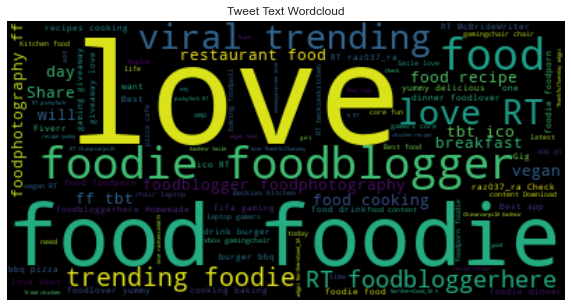

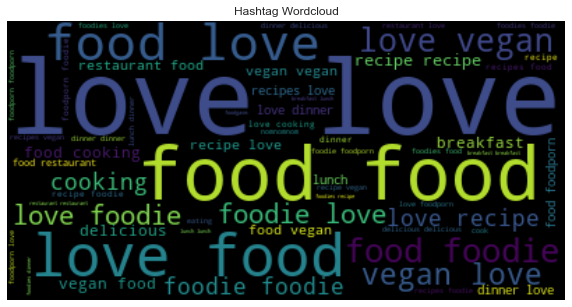

,created_at,tweet_id,user_id,user_name,screen_name,verified,tweet_text,quote_tweet,rewteet_count,favorite_count,...,user_mentions,symbols,media,hashtags_indices,urls_url,urls_expanded_url,urls_display_url,urls_indices,city_state_from_place,zipcodes
0,2021-10-20 00:49:14+00:00,1450625119575941124,1.437386e+18,Terrence Weinman,TerrenceWeinman,False,RT @TABOOOFFICIAL2: Our Taboo girls are having...,False,0.0,0,...,"[{'screen_name': 'TABOOOFFICIAL2', 'name': 'TA...",[],nan,"[79, 84]",nan,nan,nan,nan,None,nan
1,2021-10-20 00:49:14+00:00,1450625119575941124,1.437386e+18,Terrence Weinman,TerrenceWeinman,False,RT @TABOOOFFICIAL2: Our Taboo girls are having...,False,0.0,0,...,"[{'screen_name': 'TABOOOFFICIAL2', 'name': 'TA...",[],nan,"[85, 89]",nan,nan,nan,nan,None,nan
2,2021-10-20 00:49:14+00:00,1450625119575941124,1.437386e+18,Terrence Weinman,TerrenceWeinman,False,RT @TABOOOFFICIAL2: Our Taboo girls are having...,False,0.0,0,...,"[{'screen_name': 'TABOOOFFICIAL2', 'name': 'TA...",[],nan,"[90, 103]",nan,nan,nan,nan,None,nan
3,2021-10-20 00:49:14+00:00,1450625119575941124,1.437386e+18,Terrence Weinman,TerrenceWeinman,False,RT @TABOOOFFICIAL2: Our Taboo girls are having...,False,0.0,0,...,"[{'screen_name': 'TABOOOFFICIAL2', 'name': 'TA...",[],nan,"[104, 113]",nan,nan,nan,nan,None,nan
4,2021-10-20 00:49:14+00:00,1450625119575941124,1.437386e+18,Terrence Weinman,TerrenceWeinman,False,RT @TABOOOFFICIAL2: Our Taboo girls are having...,False,0.0,0,...,"[{'screen_name': 'TABOOOFFICIAL2', 'name': 'TA...",[],nan,"[114, 121]",nan,nan,nan,nan,None,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288361,2021-12-03 10:59:55+00:00,1466723868375015425,3.076684e+09,Bizmalawi,Bizmalawi,False,CP 2000\nSundowner BBQ Range\n\nMore Info:- \n...,False,0.0,0,...,[],[],nan,"[91, 98]",https://t.co/rOmguKqbR7,https://twitter.com/i/web/status/1466723868375...,twitter.com/i/web/status/1…,"[117, 140]",None,nan
288362,2021-12-03 10:59:55+00:00,1466723868375015425,3.076684e+09,Bizmalawi,Bizmalawi,False,CP 2000\nSundowner BBQ Range\n\nMore Info:- \n...,False,0.0,0,...,[],[],nan,"[99, 115]",https://t.co/Uy9DUoLH2Z,https://www.bizmalawionline.com/listing/cp-2000/,bizmalawionline.com/listing/cp-200…,"[41, 64]",None,nan
288363,2021-12-03 10:59:55+00:00,1466723868375015425,3.076684e+09,Bizmalawi,Bizmalawi,False,CP 2000\nSundowner BBQ Range\n\nMore Info:- \n...,False,0.0,0,...,[],[],nan,"[99, 115]",https://t.co/rOmguKqbR7,https://twitter.com/i/web/status/1466723868375...,twitter.com/i/web/status/1…,"[117, 140]",None,nan
288364,2021-12-03 10:59:59+00:00,1466723884519022601,9.908415e+07,Ciara & Zoppy Fitzgerald,Kilts4me,False,I haven't triedd this....but man it looks good...,False,0.0,0,...,[],[],nan,"[47, 53]",https://t.co/qdak4xdOwn,https://theiranianvegan.com/recipes/vegan-pers...,theiranianvegan.com/recipes/vegan-…,"[66, 89]",None,nan


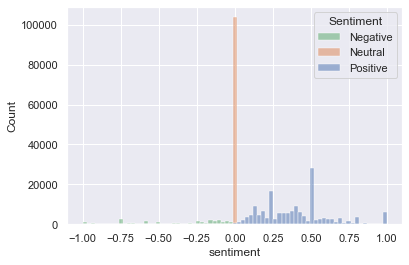

<Figure size 720x720 with 0 Axes>

In [215]:
df = clean_data()
df

In [227]:
df['zipcodes'].value_counts()

nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [229]:
# Write to directory
to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
file_name = os.path.join(data_path, 'all_data.csv')
df.to_csv(file_name, encoding='utf-8-sig')